In [25]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Wed Jan 23 15:16:27 2019

@author: Ruoyan Wang
"""

import h5py
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
#import sys as sys
#from scipy import optimize
#from astropy.stats import LombScargle
#from astropy.stats import BoxLeastSquares
#from astropy.stats import BoxLeastSquaresResults

In [26]:
### Read in TESS data.

# Acquired from TESS alerts
# Period in days, duration in hours

#2429414, P = 8.14, RA = 354.9, Dec = -69.1, TD = 3.58e3 #Wrong
#2372716, P = 11.53508, RA = 4.4, Dec = -66.3, TD = 2.39e3
#2105496, P = 18.361, RA = 47.5, Dec = -50.8, TD = 1.28e3

tess_file = 'tess_2017081.fits'
tess_data = fits.getdata(tess_file)
#tess_data.dtype.names
tess_time=tess_data['TIME']
tess_sap_flux=tess_data['SAP_FLUX']

### Read in MASCARA data.

mascara_file_Q1 = 'red0_vmag_2018Q1LSS.hdf5'
mascara_file_Q2 = 'red0_vmag_2018Q2LSS.hdf5'#sys.argv[2]
mascara_file_Q3 = 'red0_vmag_2018Q3LSS.hdf5'
mascara_file_Q4 = 'red0_vmag_2018Q4LSS.hdf5'

with h5py.File(mascara_file_Q1, 'r') as f:

    grp = f['lightcurves']
    grp2 = f['stars']
    vmag = grp2['vmag'][()]
    ascc = grp2['ascc'][()]

#print(max(vmag))
#plt.hist(vmag)
#print(ascc)
#print(ascc[np.where(vmag>8.4)])
    lc_Q1 = grp['2017081'][()]

# Print fields of recarray.
#print (lc1.dtype.names)

# Remove points binned from <=45 points.
mask_Q1 = lc_Q1['nobs'] > 45
lc_Q1 = lc_Q1[mask_Q1]

# Convert lst sequence to lst index.
lstidx_Q1 = lc_Q1['lstseq'] % 270


with h5py.File(mascara_file_Q2, 'r') as f:

    grp = f['lightcurves']
    lc_Q2 = grp['2017081'][()]

# Print fields of recarray.
#print (lc1.dtype.names)

# Remove points binned from <=45 points.
mask_Q2 = lc_Q2['nobs'] > 45
lc_Q2 = lc_Q2[mask_Q2]

# Convert lst sequence to lst index.
lstidx_Q2 = lc_Q2['lstseq'] % 270


with h5py.File(mascara_file_Q3, 'r') as f:
    
    grp = f['lightcurves']
    lc_Q3 = grp['2017081'][()]

# Remove points binned from <=45 points.
mask_Q3 = lc_Q3['nobs'] > 45
lc_Q3 = lc_Q3[mask_Q3]

# Convert lst sequence to lst index.
lstidx_Q3 = lc_Q3['lstseq'] % 270
    
    
with h5py.File(mascara_file_Q4, 'r') as f:

    grp = f['lightcurves']
    lc_Q4 = grp['2017081'][()]
    
# Remove points binned from <=45 points.
mask_Q4 = lc_Q4['nobs'] > 45
lc_Q4 = lc_Q4[mask_Q4]

# Convert lst sequence to lst index.
lstidx_Q4 = lc_Q4['lstseq'] % 270

# Combine lst indext and Julian dates of all seasons.
mascara_jd = np.concatenate([lc_Q1['jd'],lc_Q2['jd'],lc_Q3['jd'],lc_Q4['jd']])
mascara_lstidx = np.concatenate([lstidx_Q1,lstidx_Q2,lstidx_Q3,lstidx_Q4])

In [27]:
### Tess data reduction. Referencing fitsread.py by Keegan Thomson-Paressant.

# I defined a range of values to replace with NaNs wherever I see weird points in the data.
# Certainly not optimised, but works as a brute force approach in the short term.

flagvals=[1340,1346,2298,3006,5119,5403,6977,6983,6986,6987,6998,7013,7234,8233,8760,9034,11809,13661,13671,
          13849,13937,15424,15763,15764,17335,17352,17401,17414,17415,17433,18975,19002,19006,19076,19240,19725]

#[15887:17320]

# Replace any values below a generous flux value with NaNs, as well as any of the flagged points defined earlier.
for i in range(len(tess_sap_flux)):
    if tess_sap_flux[i] < 29800:
        tess_sap_flux[i] = np.nan
        i+=1
    else:
        i+=1

for j in flagvals:
    tess_sap_flux[j] = np.nan
    j+=1

for k in range(15887,17321):
    tess_sap_flux[k] = np.nan
    k+=1

# Temporarily replace the NaNs with zeroes in another array in order to calculate the mean, 
# as NaN prevents it from working.

vals=[]
for l in range(len(tess_sap_flux)):
    if (np.isnan(tess_sap_flux[l])):
        vals=vals
    else:
        vals.append(tess_sap_flux[l])

normflux=tess_sap_flux/np.nanmean(vals)

# Define a polynomial fit, specifying to define it only where time and flux are finite (i.e. not NaNs), 
# and divide it from the data.

idx=np.isfinite(tess_time) & np.isfinite(normflux)
coefs = np.polynomial.polynomial.polyfit(tess_time[idx],normflux[idx],1)
flux_fit=np.polynomial.polynomial.polyval(tess_time,coefs)
corrected_flux=(normflux-flux_fit)/flux_fit

# Remove outliers.
corrected_flux[np.logical_or(corrected_flux<-0.005, corrected_flux>0.003)] = np.nan
#corrected_flux = corrected_flux[np.isfinite(corrected_flux)]
tess_flux = corrected_flux 


#remove_outliers = np.where((corrected_flux < np.nanmean(corrected_flux)+6.*
#                                np.nanstd(corrected_flux))*
#                               (corrected_flux > np.nanmean(corrected_flux) - 6.*
#                                np.nanstd(corrected_flux)))

#tess_flux = tess_flux[remove_outliers]

tess_time = tess_time[np.where(tess_flux)]


IndexError: index 2298 is out of bounds for axis 0 with size 1960

In [28]:
### Secondary data calibriation on MASCARA by Local linear method.

# Compute a moving mean along the x-axis.
def moving_mean(x, y, yerr=None, window=3.):
    
    # Set the weights.
    if yerr is None:
        weights = np.ones_like(y)
    else:
        weights = 1/yerr**2

    # Sums for computing the mean.
    sum1 = np.append(0, np.cumsum(weights*y))
    sum2 = np.append(0, np.cumsum(weights))
    
    # Indices at the start and end of the window.
    i = np.searchsorted(x, x - window/2.)
    j = np.searchsorted(x, x + window/2.)
    
    # Compute the mean.
    mean = (sum1[j] - sum1[i])/(sum2[j] - sum2[i])
    
    return mean

# Fit a curve for local linear
def linfit(lstidx, x, y, sky, mag, emag):
    
    sort = np.argsort(lstidx)
    invsort = np.argsort(sort)
    
    lstidx = lstidx[sort]
    x = x[sort]
    y = y[sort]
    sky = sky[sort]
    mag = mag[sort]
    emag = emag[sort]

    _, idx = np.unique(lstidx, return_inverse=True)

    nobs = np.bincount(idx)
    strides = np.append(0, np.cumsum(nobs))

    xbar = np.bincount(idx, x)/np.bincount(idx)
    ybar = np.bincount(idx, y)/np.bincount(idx)

    mat = np.column_stack([np.ones(len(lstidx)), x-xbar[idx], y-ybar[idx], sky])

    pars = np.zeros((len(nobs), 4))
    pars[:,0] = np.bincount(idx, mag/emag**2)/np.bincount(idx, 1/emag**2)

    for i in range(len(nobs)):

        if nobs[i] < 5:
             continue

        i1 = strides[i]
        i2 = strides[i+1]

        pars[i] = np.linalg.lstsq(mat[i1:i2]/emag[i1:i2,None], mag[i1:i2]/emag[i1:i2], rcond=None)[0]

    fit = np.sum(pars[idx]*mat, axis=1)

    fit1 = pars[idx,0]
    fit2 = fit - pars[idx,0]

    return fit1[invsort], fit2[invsort], (nobs > 4)[idx][invsort]

def local_lin(jd, lstseq, x, y, sky, mag, emag, window=5., maxiter=50, dtol=1e-3):
     
    lstidx = (lstseq % 270)
    fit0 = np.zeros(len(jd))
    fit1 = np.zeros(len(jd))

    fit = np.zeros_like(mag)
    for niter in range(maxiter):
        fit1, fit2, mask = linfit(lstidx, x, y, sky, mag - fit0, emag)
        fit0 = moving_mean(jd, mag - fit1 - fit2, emag, window)

        if niter > 0:

            if np.all(np.abs(fit - fit0 - fit1 - fit2) < dtol):
                break

        fit = fit0 + fit1 + fit2

    return fit, fit0, fit1, fit2, mask

mascara_flux_Q1 = lc_Q1['mag0']-local_lin(lc_Q1['jd'],
                                   lc_Q1['lstseq'],lc_Q1['x'],lc_Q1['y'],
                                   lc_Q1['sky'],lc_Q1['mag0'],lc_Q1['emag0'])[0]
mascara_flux_Q2 = lc_Q2['mag0']-local_lin(lc_Q2['jd'],
                                   lc_Q2['lstseq'],lc_Q2['x'],lc_Q2['y'],
                                   lc_Q2['sky'],lc_Q2['mag0'],lc_Q2['emag0'])[0]
mascara_flux_Q3 = lc_Q3['mag0']-local_lin(lc_Q3['jd'],
                                   lc_Q3['lstseq'],lc_Q3['x'],lc_Q3['y'],
                                   lc_Q3['sky'],lc_Q3['mag0'],lc_Q3['emag0'])[0]
mascara_flux_Q4 = lc_Q4['mag0']-local_lin(lc_Q4['jd'],
                                   lc_Q4['lstseq'],lc_Q4['x'],lc_Q4['y'],
                                   lc_Q4['sky'],lc_Q4['mag0'],lc_Q4['emag0'])[0]

# Collect reduced flux from all seasons.
mascara_flux = np.concatenate([mascara_flux_Q1, mascara_flux_Q2, mascara_flux_Q3, mascara_flux_Q4])

In [29]:
#np.set_printoptions(threshold=1000)
#periodogram = BoxLeastSquares(lc['jd'], delta_mag).autopower(8.56/24)
#plt.plot(periodogram.period, periodogram.power, 'k')
#plt.xlabel('Period')
#plt.ylabel('Power')
#periodogram.period[np.where(periodogram.power==max(periodogram.power))]
#periodogram

In [30]:
### Phase folding MASCARA and TESS data. 

# Convert BJD to JD. The tau value given here is a scaling factor, 
# which will be mostly correct for you, but should probably be checked.

T0 = 2457000
tau=1.3228e-8
for i in range(len(tess_time)):
    tess_time[i] = (tess_time[i]+T0)-i*tau
    
P = 9.868 # Days
#epoch = T0+1322.0828
epoch = 1471.925+T0 # BTJD


#tess_phase=((tess_time-epoch)%P)
#tess_phase = np.array([tess_phase[i]/P if tess_phase[i] < P/2. 
#                       else (tess_phase[i]-P)/P for i in range(len(tess_phase))])

tess_phase = (tess_time - epoch)/P
tess_phase = np.mod(tess_phase+.5, 1)-.5

mascara_phase = (mascara_jd - epoch)/P
mascara_phase = np.mod(mascara_phase+.5, 1)-.5


In [31]:
### Bin MASCARA data points.

def spec_digitize_mean(x,y,numbins):
    mybins = np.linspace(min(x),max(x),numbins)
    digitized = np.digitize(x,mybins)
    xmeans = [x[digitized==i].nanmean() for i in range(1,len(mybins))]
    ymeans= [y[digitized==i].nanmean() for i in range(1,len(mybins))]
    return xmeans,ymeans

def spec_digitize_median(x,y,numbins):
    mybins = np.linspace(min(x),max(x),numbins)
    digitized = np.digitize(x,mybins)
    xmedians = [np.nanmedian(x[digitized==i]) for i in range(1,len(mybins))]
    ymedians = [np.nanmedian(y[digitized==i]) for i in range(1,len(mybins))]
    return xmedians,ymedians

bins = spec_digitize_median(mascara_phase, mascara_flux, 1000)

binned_mascara_phase,binned_mascara_flux = np.asarray(bins)[0],np.asarray(bins)[1]

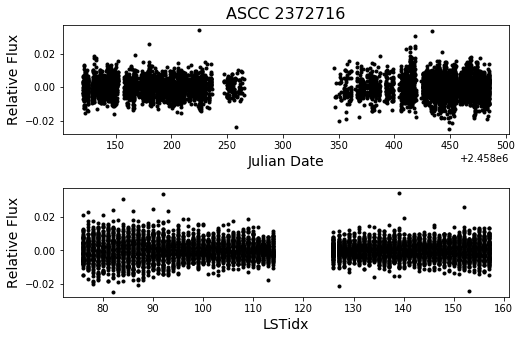

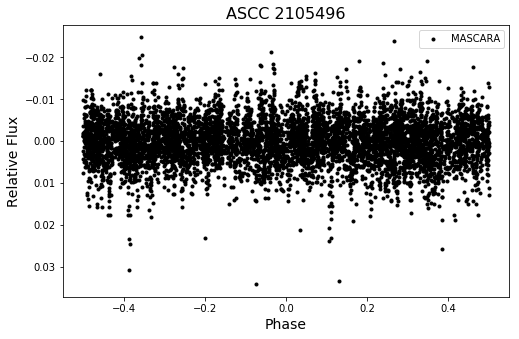

In [33]:
# Plot as a dunction of Julian date and local sidereal time.
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8,5))

# make a little extra space between the subplots
fig.subplots_adjust(hspace=0.5)

#plt.subplot(211)
ax1.plot(mascara_jd, mascara_flux, 'k.')
#ax1.invert_yaxis()
ax1.set_title('ASCC 2372716', size=16)
ax1.set_xlabel('Julian Date', fontsize=14)
ax1.set_ylabel('Relative Flux', fontsize=14)

#plt.subplot(212)
ax2.plot(mascara_lstidx, mascara_flux, 'k.')
#ax2.invert_yaxis()
ax2.set_xlabel('LSTidx', fontsize=14)
ax2.set_ylabel('Relative Flux', fontsize=14)

#plt.savefig('ASCC_2372716_jd&lst',dpi=300)



# Plot BJD versus normalised and corrected flux.

#plt.figure()
#plt.plot(tess_time,corrected_flux,linewidth=1)
#plt.xlabel('Barycentric Julian Date')
#plt.ylabel('Normalised Flux')

# Plot the final JD versus normalised and corrected flux.

#plt.figure(figsize=(8,5))
#plt.xlim(42+2.4583e6,45+2.4583e6)
#plt.plot(tess_time, corrected_flux, marker = '.', linestyle = 'None')
#plt.xlabel('Julian Date')
#plt.ylabel('Normalised Flux')

#plt.show()


#P = periodogram.period[np.where(periodogram.power==max(periodogram.power))]
#delta_mag[np.logical_or(delta_mag<-0.01, delta_mag>0.01)] = 0

# Plot as a function of phase.

#plt.figure(figsize=(8,5))
#plt.plot(tess_phase, tess_flux, marker = '.', color = 'gold', linestyle = 'None')

plt.figure(figsize=(8,5))

plt.plot(mascara_phase,mascara_flux,'.k', label = 'MASCARA')
#plt.plot(binned_mascara_phase, binned_mascara_flux, marker = '.', 
#         color = 'deepskyblue', linestyle = 'None', label = 'Binned MASCARA')
#plt.plot(tess_phase, tess_flux, marker = '.', color = 'gold', linestyle = 'None',  label = 'TESS',alpha=0.05)

#plt.xlim(-0.1,0.1)
#plt.ylim(-0.03,0.03)
plt.gca().invert_yaxis()
plt.title('ASCC 2105496', fontsize=16)
plt.xlabel('Phase' ,fontsize=14)
plt.ylabel('Relative Flux', fontsize=14)
plt.legend(loc='best')
#plt.annotate('P = 0.81304',color='k',xy=(-0.2,0.065),fontsize=13)
#plt.show()
#plt.savefig('ASCC_2372716_phasefold_bin', dpi=300)